In [3]:
# Reload and changes to module without having to restart kernel.
%load_ext autoreload
%autoreload 2

- imbalance, absolute standardised difference (before matching, after PSM, after MDM) *done*
- histograms of variables (before matching, after PSM, after MDM) *done*
- histograms of causal variable and outcome variable (before matching, after PSM, after MDM)
- ATE, average outcome for g0 and g1, ttest and nonparametric (before matching, after PSM, after MDM) *done*
- number of matched g0s (after PSM, after MDM)

# Imports

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import loneliness.psm as psm
import loneliness.mdm as mdm
import loneliness.measures as measures
import loneliness.plots as plots

# Load features matrix

In [6]:
features = pd.read_csv("features.csv", index_col='pcstrip')

feature_vars_all = ['ru_rank', 'moves_in_zscore',
                'gp_norm_gp0_9', 'gp_norm_gp10_24', 'gp_norm_gp25_49',
                'gp_norm_gp50_79', 'gp_norm_gp80p', 'index_multiple_deprivation',
                'nearby_schools_zscore']

features = features[feature_vars_all+['target']]

# Mahalanobis Distance Matching

In [29]:
tests = ['nearby_schools_zscore', 'gp_norm_gp80p', 'gp_norm_gp10_24', 'moves_in_zscore', 'ru_rank', 'index_multiple_deprivation']

for treatment_name in tests:

    feature_vars = np.setdiff1d(feature_vars_all, [treatment_name])

#     treatment = psm.create_treatment_variable(features[treatment_name], criteria='median')

#     features[treatment.name] = treatment

#     matches, group_0_mdm, group_1_mdm = mdm.nearest_neighbours_match(control_group, treatment_group, features, feature_vars)
    distances = mdm.compute_distances(features, feature_vars)

    distances.to_csv("distances_{}.csv".format(treatment_name))

Created boolean feature 'nearby_schools_zscore_bool_median'. 
Feature distribution: [3255 3239]


/anaconda3/lib/python3.6/site-packages/scipy/spatial/distance.py:1066: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(m)


Created boolean feature 'gp_norm_gp80p_bool_median'. 
Feature distribution: [3247 3247]


Created boolean feature 'gp_norm_gp10_24_bool_median'. 
Feature distribution: [3247 3247]


Created boolean feature 'moves_in_zscore_bool_median'. 
Feature distribution: [3263 3231]


Created boolean feature 'ru_rank_bool_median'. 
Feature distribution: [3633 2861]


Created boolean feature 'index_multiple_deprivation_bool_median'. 
Feature distribution: [3248 3246]


# Propensity Score Matching (NN)

In [73]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

clf_nn = MLPClassifier(solver='lbfgs', alpha=0.01, hidden_layer_sizes=(50,50,50,), learning_rate='adaptive', max_iter=500)
clf_lr = LogisticRegression(solver='liblinear', penalty='l2')

In [74]:
features['prop_score'] = psm.get_propensity_scores(treatment, features[feature_vars], return_labels = False, classifier=clf_nn)

prop score accuracy:  0.8826609177702495


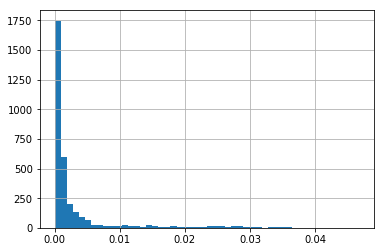

In [75]:
matches, group_0_psm, group_1_psm = psm.propensity_match(features, treatment, prune = 0.005)

### Average treatment effect after Propensity Score Matching

In [76]:
ate_psm_nn, ttest_psm_nn, mwu_psm_nn = measures.average_treatment_effect(g0=group_0_psm, g1=group_1_psm)

ATE: 0.24842719727532891


### Imbalance (absolute standardised difference) after Propensity Score Matching

In [77]:
asd_psm_nn = measures.absolute_standardised_difference(features, feature_vars, g0=group_0_psm, g1=group_1_psm)

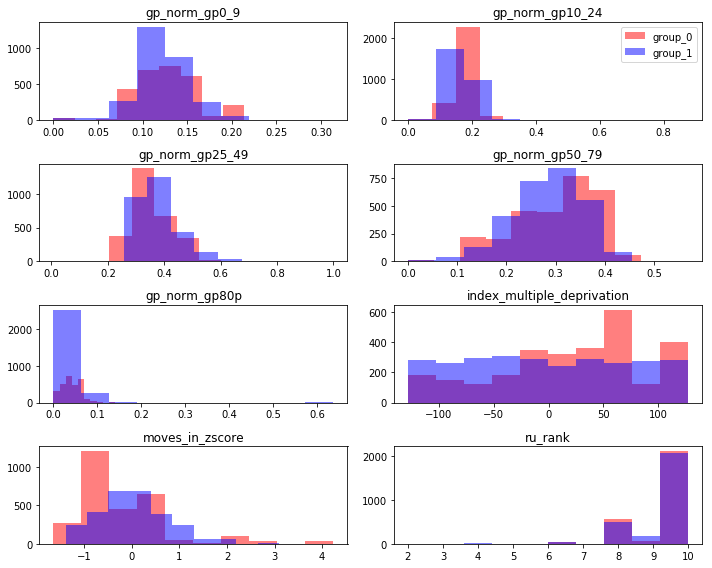

In [78]:
plots.var_histograms_matched(group_0_psm, group_1_psm, feature_vars)

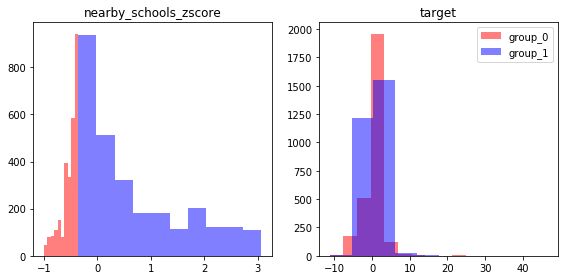

In [79]:
plots.var_histograms_matched_causal_target(group_0_psm, group_1_psm, treatment, treatment_name)

In [80]:
matches_g0_psm_nn = len(np.unique(group_0_psm.index.values))
print("# GP's in G0 matched to a GP in G1 = {}, ({:.1f}%)".format( matches_g0_psm,100*matches_g0_psm/len(group_0_psm.index.values)  ))

# GP's in G0 matched to a GP in G1 = 596, (21.3%)


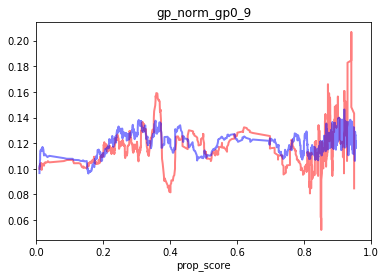

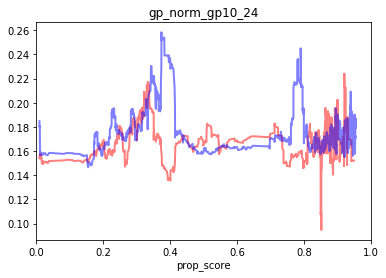

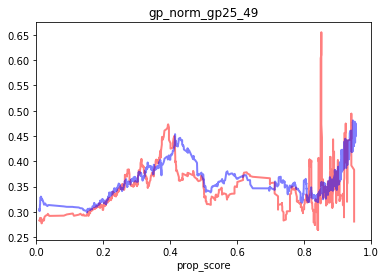

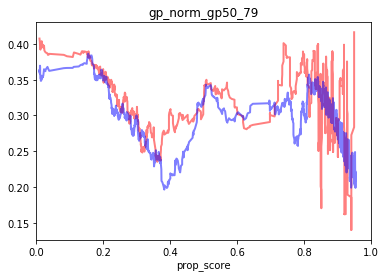

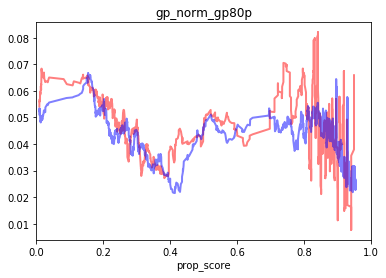

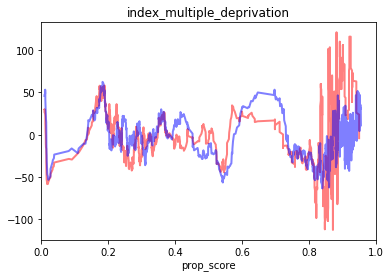

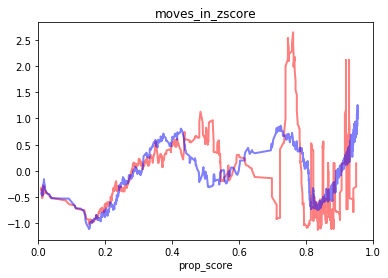

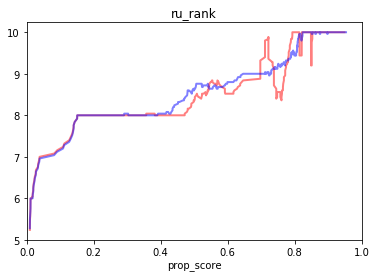

In [81]:
plots.var_vs_prop(features, feature_vars, treatment, group_0_psm, group_1_psm)